Part 1 — Vanilla VAE (20 pts)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim):
        super().__init__()

        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)   # μ
        self.fc22 = nn.Linear(n_hid, z_dim)   # log σ^2
        self.fc3 = nn.Linear(z_dim, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def encode(self, x, c=None):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z, c=None):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
        
    def forward(self, x, c=None):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, c)
        return recon, mu, logvar

In [4]:
from torch.optim import Adam
n_in = 784
n_hid = 400
z_dim = 20
learning_rate = 1e-3
batch_size = 128

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [6]:
from torch.optim import Adam
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_set = FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

vae = VAE(784, 400, 20).to(device)
optimizer = Adam(vae.parameters(), lr=1e-3)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 249kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:14<00:00, 312kB/s] 


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [7]:
def train_vae(epoch):
    vae.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)

        optimizer.zero_grad()
        recon, mu, logvar = vae(x)
        loss = loss_function(recon, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch}, Train Loss = {train_loss/len(train_loader.dataset):.4f}")


In [8]:
for epoch in range(1, 21):
    train_vae(epoch)
torch.save(vae.state_dict(), "vanilla_vae.pth")


Epoch 1, Train Loss = 285.1780
Epoch 2, Train Loss = 256.3350
Epoch 3, Train Loss = 250.6281
Epoch 4, Train Loss = 247.8835
Epoch 5, Train Loss = 246.2866
Epoch 6, Train Loss = 245.0746
Epoch 7, Train Loss = 244.2682
Epoch 8, Train Loss = 243.5346
Epoch 9, Train Loss = 243.0354
Epoch 10, Train Loss = 242.6091
Epoch 11, Train Loss = 242.1876
Epoch 12, Train Loss = 241.8690
Epoch 13, Train Loss = 241.5702
Epoch 14, Train Loss = 241.3657
Epoch 15, Train Loss = 241.1126
Epoch 16, Train Loss = 240.9270
Epoch 17, Train Loss = 240.7576
Epoch 18, Train Loss = 240.5478
Epoch 19, Train Loss = 240.3954
Epoch 20, Train Loss = 240.2716


Part 2 — Conditional VAE (C-VAE) (10 pts)

In [9]:
class CVAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim, n_classes=10):
        super().__init__()
        self.n_classes = n_classes

        self.fc1 = nn.Linear(n_in + n_classes, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)
        self.fc22 = nn.Linear(n_hid, z_dim)
        self.fc3 = nn.Linear(z_dim + n_classes, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def onehot(self, c):
        return F.one_hot(c, num_classes=self.n_classes).float()

    def encode(self, x, c):
        xc = torch.cat([x, self.onehot(c)], dim=1)
        h = torch.relu(self.fc1(xc))
        mu = self.fc21(h)
        logvar = self.fc22(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        zc = torch.cat([z, self.onehot(c)], dim=1)
        h = torch.relu(self.fc3(zc))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, c)
        return recon, mu, logvar


In [10]:
cvae = CVAE(784, 400, 20).to(device)
optimizer_c = Adam(cvae.parameters(), lr=1e-3)

def train_cvae(epoch):
    cvae.train()
    train_loss = 0
    for x, c in train_loader:
        x = x.view(-1, 784).to(device)
        c = c.to(device)

        optimizer_c.zero_grad()
        recon, mu, logvar = cvae(x, c)
        loss = loss_function(recon, x, mu, logvar)
        loss.backward()
        optimizer_c.step()
        train_loss += loss.item()

    print(f"C-VAE Epoch {epoch}, Train Loss = {train_loss/len(train_loader.dataset):.4f}")

for epoch in range(1, 21):
    train_cvae(epoch)

torch.save(cvae.state_dict(), "cvae.pth")


C-VAE Epoch 1, Train Loss = 283.4097
C-VAE Epoch 2, Train Loss = 253.8810
C-VAE Epoch 3, Train Loss = 248.2097
C-VAE Epoch 4, Train Loss = 245.3089
C-VAE Epoch 5, Train Loss = 243.5054
C-VAE Epoch 6, Train Loss = 242.2872
C-VAE Epoch 7, Train Loss = 241.2971
C-VAE Epoch 8, Train Loss = 240.5478
C-VAE Epoch 9, Train Loss = 239.9320
C-VAE Epoch 10, Train Loss = 239.4041
C-VAE Epoch 11, Train Loss = 238.9769
C-VAE Epoch 12, Train Loss = 238.6009
C-VAE Epoch 13, Train Loss = 238.2743
C-VAE Epoch 14, Train Loss = 237.9843
C-VAE Epoch 15, Train Loss = 237.7522
C-VAE Epoch 16, Train Loss = 237.4665
C-VAE Epoch 17, Train Loss = 237.3151
C-VAE Epoch 18, Train Loss = 237.0939
C-VAE Epoch 19, Train Loss = 236.9566
C-VAE Epoch 20, Train Loss = 236.7892


Part 3 — t-SNE Manifold Visualization (15 pts)

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def extract_mu(model):
    model.eval()
    Z = []
    Y = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.view(-1, 784).to(device)
            y = y.to(device)
            mu, logvar = model.encode(x, y) if isinstance(model, CVAE) else model.encode(x, None)
            Z.append(mu.cpu())
            Y.append(y.cpu())
    return torch.cat(Z), torch.cat(Y)


In [12]:
def plot_tsne(Z, Y, title):
    Z2d = TSNE(n_components=2).fit_transform(Z)
    plt.figure(figsize=(8,8))
    plt.scatter(Z2d[:,0], Z2d[:,1], c=Y, cmap='tab10', s=10)
    plt.colorbar()
    plt.title(title)
    plt.show()


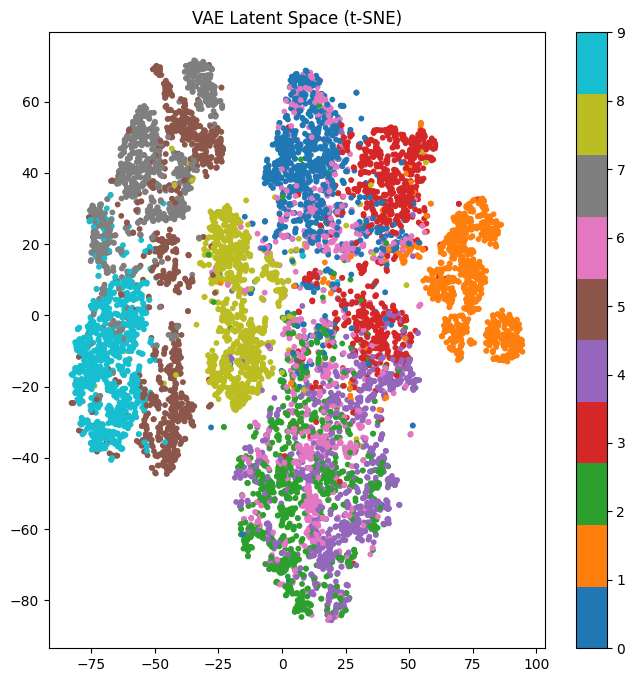

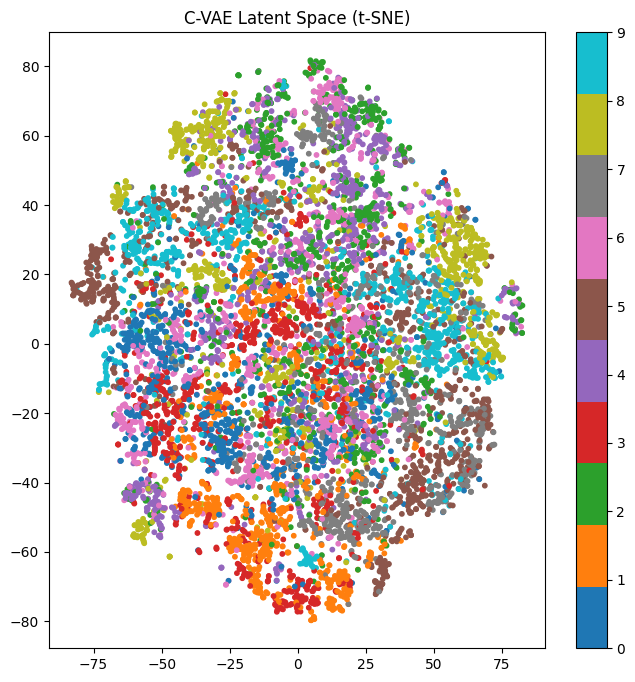

In [13]:
Z_vae, Y_vae = extract_mu(vae)
plot_tsne(Z_vae, Y_vae, "VAE Latent Space (t-SNE)")

Z_cvae, Y_cvae = extract_mu(cvae)
plot_tsne(Z_cvae, Y_cvae, "C-VAE Latent Space (t-SNE)")
